<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/Distilbert_ita_doppio_val_hyp_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


# Data loading

In [48]:
df_dev = load_dataset("csv", data_files="dataset/subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

# Data partioning

In [6]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=0)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [7]:
df_train = train_val["train"]
df_val_ = train_val["test"]

In [8]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val_ = df_val_.rename_column("comment_text", "text")
df_val_ = df_val_.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

In [9]:
df_val_

Dataset({
    features: ['text', 'labels'],
    num_rows: 552
})

In [10]:
df_val_ = df_val_.train_test_split(test_size=0.3, seed=0)

In [11]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 386
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 166
    })
})

In [12]:
df_val = df_val_["train"]
df_val2 = df_val_["test"]

In [13]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1288
})

In [14]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 386
})

In [15]:
df_val2

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

# Model loading

In [16]:
nome = 'distilbert-base-it-cased'
model_name = 'Geotrend/distilbert-base-it-cased'

In [17]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [19]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Training

In [49]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [342]:
def hyperparameter_search(model_name=model_name, optim='adagrad', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=13,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    return config, training_args, model

In [343]:
dropout = 0.2
learning_rate = 0.00003

config, training_args, model = hyperparameter_search(dropout=dropout, learning_rate=learning_rate)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [310]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(25496, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [228]:
config

DistilBertConfig {
  "_name_or_path": "Geotrend/distilbert-base-it-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.05,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.31.0",
  "vocab_size": 25496
}

In [ ]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.641000,0.578483,0.715433
2,0.579300,0.537603,0.748568


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py", line 1327, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1539, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1916, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2212, in _maybe_log_save_evaluate
    self.log(logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2570, in log
    self.control = self.callback_handler.on_log(self.args, self.state, self.control, logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer_callback.py", line 390, in on_log
    return self.call_event("on_log", args, s

# Evaluation

In [344]:
log_history = trainer.state.log_history

In [345]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [346]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
#df

In [ ]:
# df.to_html(f'loss_{nome}.html')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-347-b7bf952ec227>", line 6, in <cell line: 6>
    plt.savefig(f'loss_curves_{nome}_doppioval_loss.pdf', dpi=300, bbox_inches='tight')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backe

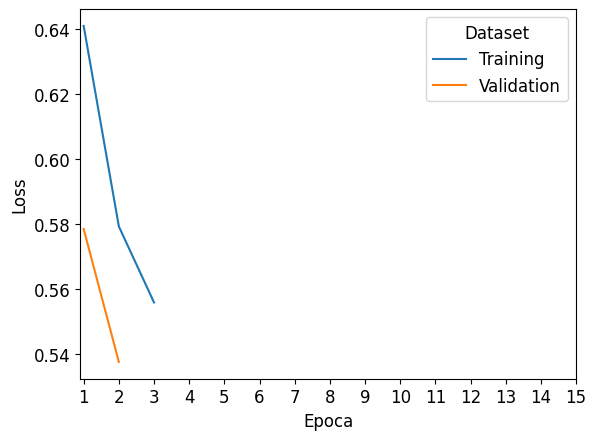

In [ ]:
# loss lineplot
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_doppioval_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_predictions_val2 = trainer.predict(tokenized_val2)

Epoch,Training Loss,Validation Loss,F1
1,0.641000,0.578483,0.715433
2,0.579300,0.537603,0.748568


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-347-7b30aeaaf84e>", line 1, in <cell line: 1>
    output_predictions_val2 = trainer.predict(tokenized_val2)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3010, in predict
    output = eval_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3222, in evaluation_loop
    metrics = self.compute_metrics(EvalPrediction(predictions=all_preds, label_ids=all_labels))
  File "<ipython-input-49-17fce5bfb034>", line 3, in compute_metrics
    f1_metric = evaluate.load("f1")
  File "/usr/local/lib/python3.10/dist-packages/evaluate/loading.py", line 752, in load
    evaluation_instance.download_and_prepare(download_config=download_config)
  File "/usr/local/lib/python3.10/dist-packages/evaluate/module.py", line 650, in d

In [347]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_predictions_val2.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.51      1.00      0.68        85

    accuracy                           0.51       166
   macro avg       0.26      0.50      0.34       166
weighted avg       0.26      0.51      0.35       166



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
with open(f"class_report_{nome}_doppioval_f1.html", "w") as file:
    file.write(report)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-348-95aa3f87c918>", line 1, in <cell line: 1>
    with open(f"class_report_{nome}_doppioval_f1.html", "w") as file:
OSError: [Errno 107] Transport endpoint is not connected: 'class_report_distilbert-base-it-cased_doppioval_f1.html'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_get

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-348-3cdd7c1a079d>", line 7, in <cell line: 7>
    plt.savefig(f'conf_matrix_{nome}_doppioval_f1.pdf', dpi=300, bbox_inches='tight')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backend

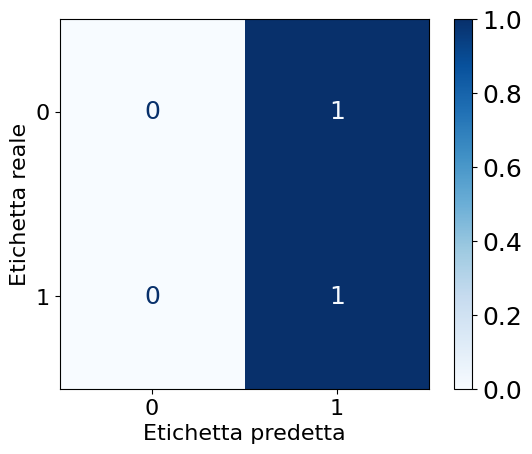

In [ ]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_doppioval_f1.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [348]:
from sklearn.metrics import f1_score

In [349]:
f1_val2 = f1_score(y_val, y_val_pred, average='macro')

In [ ]:
output_predictions_val = trainer.predict(tokenized_val)

Epoch,Training Loss,Validation Loss,F1
1,0.641000,0.578483,0.715433
2,0.579300,0.537603,0.748568


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-350-32776b11dc75>", line 1, in <cell line: 1>
    output_predictions_val = trainer.predict(tokenized_val)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3010, in predict
    output = eval_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3222, in evaluation_loop
    metrics = self.compute_metrics(EvalPrediction(predictions=all_preds, label_ids=all_labels))
  File "<ipython-input-49-17fce5bfb034>", line 3, in compute_metrics
    f1_metric = evaluate.load("f1")
  File "/usr/local/lib/python3.10/dist-packages/evaluate/loading.py", line 752, in load
    evaluation_instance.download_and_prepare(download_config=download_config)
  File "/usr/local/lib/python3.10/dist-packages/evaluate/module.py", line 650, in dow

In [350]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions_val.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       191
           1       0.51      1.00      0.67       195

    accuracy                           0.51       386
   macro avg       0.25      0.50      0.34       386
weighted avg       0.26      0.51      0.34       386



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [351]:
f1_val = f1_score(y_val, y_val_pred, average='macro')

In [352]:
print(f"L'F1 sul primo val è di {f1_val:0.2}, mentre sul secondo val di {f1_val2:0.2}. \nIl modello è quello con l'F1 più alto.")

L'F1 sul primo val è di 0.34, mentre sul secondo val di 0.34. 
Il modello è quello con l'F1 più alto.


In [298]:
model_directory = 'distilbert-base-it-cased-finetuned/checkpoint-2093'

In [299]:
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

In [300]:
trainer = Trainer(model=model)

In [301]:
output_prediction_f1 = trainer.predict(tokenized_val2)

In [302]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction_f1.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.70      0.68        81
           1       0.70      0.65      0.67        85

    accuracy                           0.67       166
   macro avg       0.68      0.68      0.67       166
weighted avg       0.68      0.67      0.67       166



In [303]:
f1_val2 = f1_score(y_val, y_val_pred, average='macro')

In [304]:
output_predictions_f1_val = trainer.predict(tokenized_val)

In [305]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions_f1_val.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       191
           1       0.78      0.78      0.78       195

    accuracy                           0.78       386
   macro avg       0.78      0.78      0.78       386
weighted avg       0.78      0.78      0.78       386



In [306]:
f1_val = f1_score(y_val, y_val_pred, average='macro')

In [307]:
print(f"L'F1 sul primo val è di {f1_val:0.2}, mentre sul secondo val di {f1_val2:0.2}. \nIl modello è quello con la loss più bassa.")

L'F1 sul primo val è di 0.78, mentre sul secondo val di 0.67. 
Il modello è quello con la loss più bassa.


In questo caso è migliore sul secondo val il modello con l'F1 più alto